In [1]:
# Data Handling
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import os, datetime, copy
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import tensorflow as tf

# Models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, metrics, losses
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
window_size = 10

base_dir = os.getcwd()
data_dir = f'{base_dir}\\Data\\1.xlsx'
df = pd.read_excel(data_dir, header=1)
for col in ['china', 'usa', 'japan', 'russia']:
    df[col] = df[col]*1000
df.head()


,سال,iran,india,china,usa,russia,saudi,japan,south k,germany,indo,brazil
0,1981,113.00,314.97,1480000,4690000.0,2090000,175.30,926840.0,139.59,1050.0,100.30,170.61
1,1982,137.77,325.38,1610000,4450000.0,2130000,157.89,897410.0,140.78,1020.0,105.58,170.81
2,1983,149.58,352.20,1690000,4430000.0,2160000,160.84,880910.0,149.13,1010.0,105.18,165.35
3,1984,149.86,361.56,1840000,4660000.0,2180000,155.51,937070.0,160.70,1030.0,112.46,167.08
4,1985,159.86,397.59,2000000,4650000.0,2350000,172.42,912400.0,168.76,1040.0,121.60,179.59


In [3]:
countries = df.columns[1:].tolist()

1/1 [==============================] - 0s 14ms/step
       r2_score        mae         mse       rmse
all    0.981808  17.830249  517.236419  22.742832
train  0.973742  19.442226  582.881935  24.142948
val    0.857158   6.505471   56.615394   7.524320


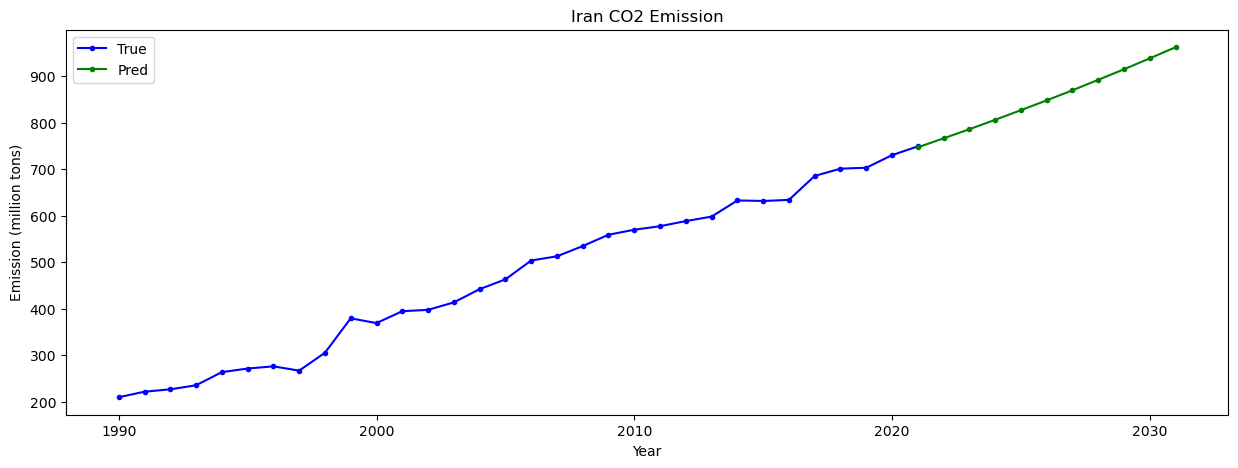

1/1 [==============================] - 0s 14ms/step
       r2_score         mae           mse        rmse
all    0.982451   72.892688   8309.454417   91.156209
train  0.979764   66.515445   6639.398968   81.482507
val   -1.253989  117.762268  19990.068702  141.386239


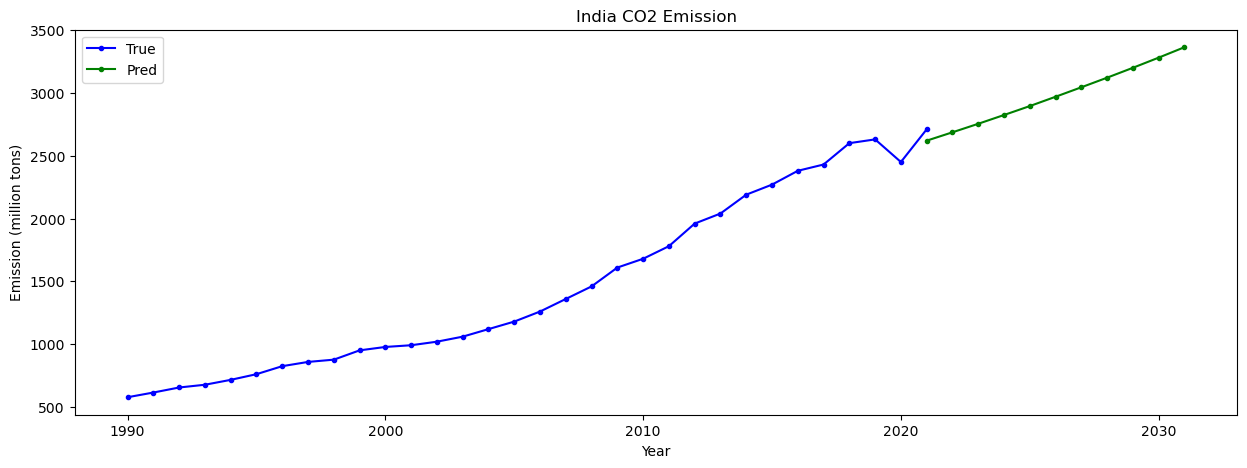

1/1 [==============================] - 0s 14ms/step
       r2_score            mae           mse           rmse
all    0.978112  318887.382812  2.081805e+11  456268.002237
train  0.969062  351682.008929  2.366074e+11  486423.040525
val    0.945150   88067.750000  8.981724e+09   94771.957731


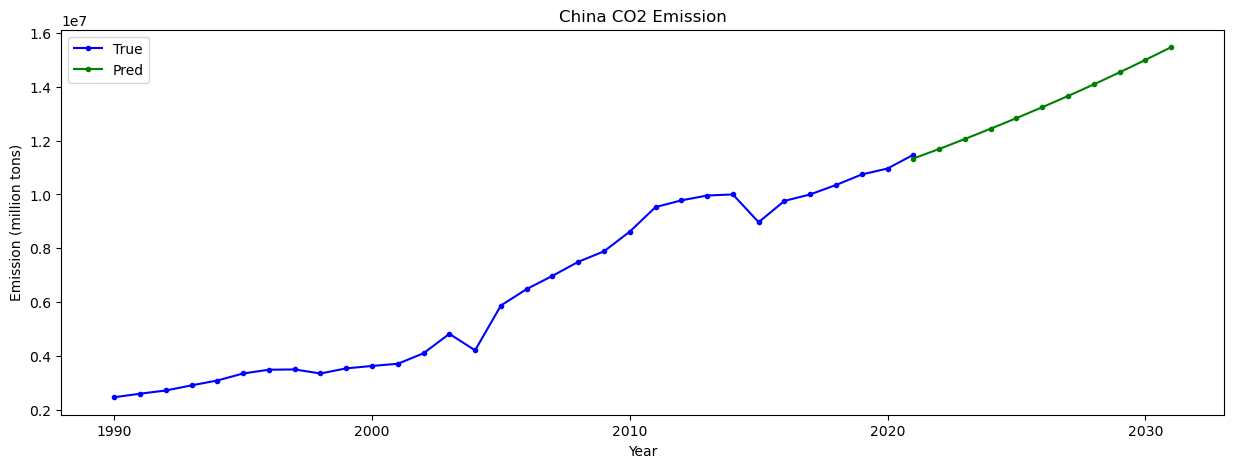

1/1 [==============================] - 0s 14ms/step
       r2_score            mae           mse          rmse
all   -0.039761  434407.765625  1.099670e+12  1.048652e+06
train -0.052273  468560.160714  1.248765e+12  1.117482e+06
val    0.132986  194864.625000  5.592240e+10  2.364792e+05


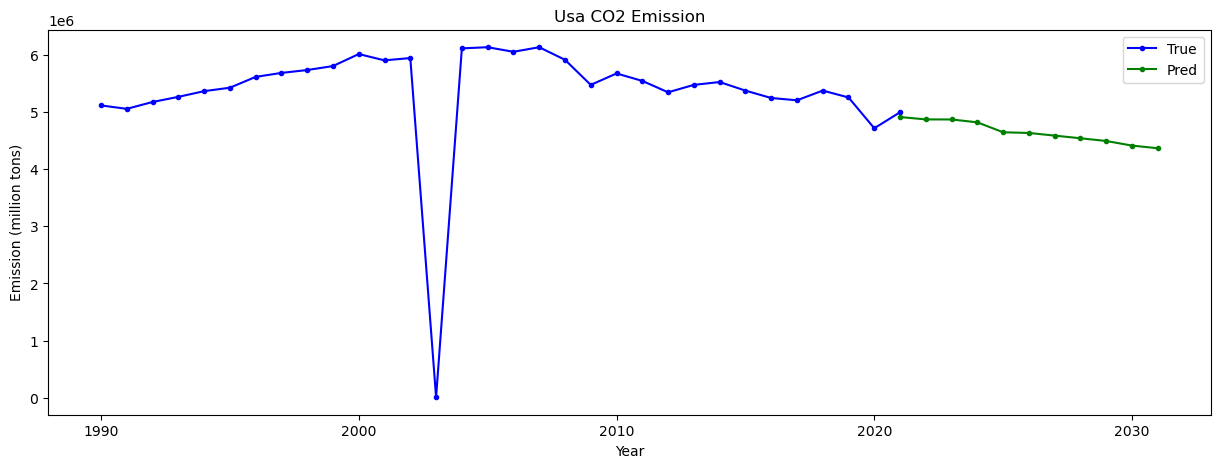

1/1 [==============================] - 0s 15ms/step
       r2_score            mae           mse           rmse
all    0.484681  117568.402344  4.954141e+10  222578.998797
train  0.486956  127624.017857  5.617409e+10  237010.734665
val   -0.264169   47265.875000  3.120917e+09   55865.166110


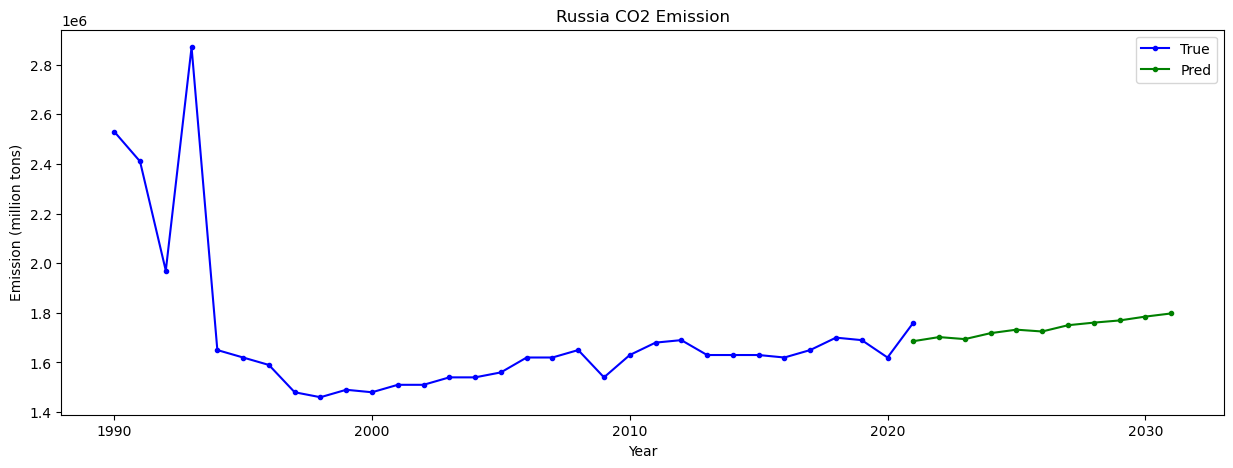

1/1 [==============================] - 0s 16ms/step
       r2_score        mae          mse       rmse
all    0.898999  41.671519  2494.403894  49.944008
train  0.858937  45.419926  2807.925981  52.989867
val   -0.028266  15.452015   300.524156  17.335633


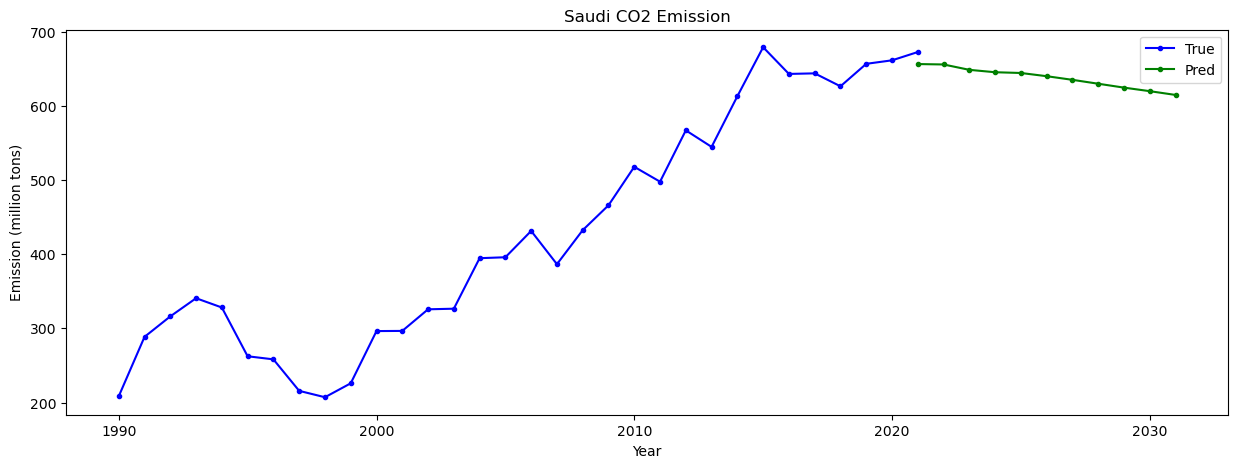

1/1 [==============================] - 0s 15ms/step
       r2_score           mae           mse          rmse
all    0.041243  52989.142578  4.254110e+09  65223.535959
train -1.054000  52225.747768  4.268339e+09  65332.524574
val   -1.897925  58673.062500  4.201991e+09  64822.763418


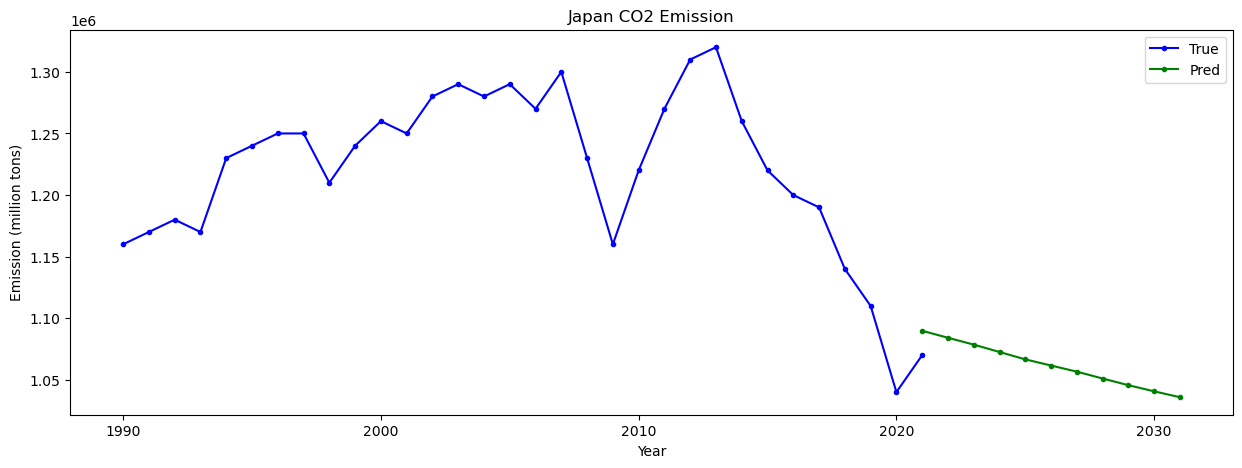

1/1 [==============================] - 0s 15ms/step
       r2_score        mae          mse       rmse
all    0.915201  28.306237  1237.027193  35.171397
train  0.920248  26.481760  1098.558549  33.144510
val   -1.843321  40.741847  2196.125575  46.862838


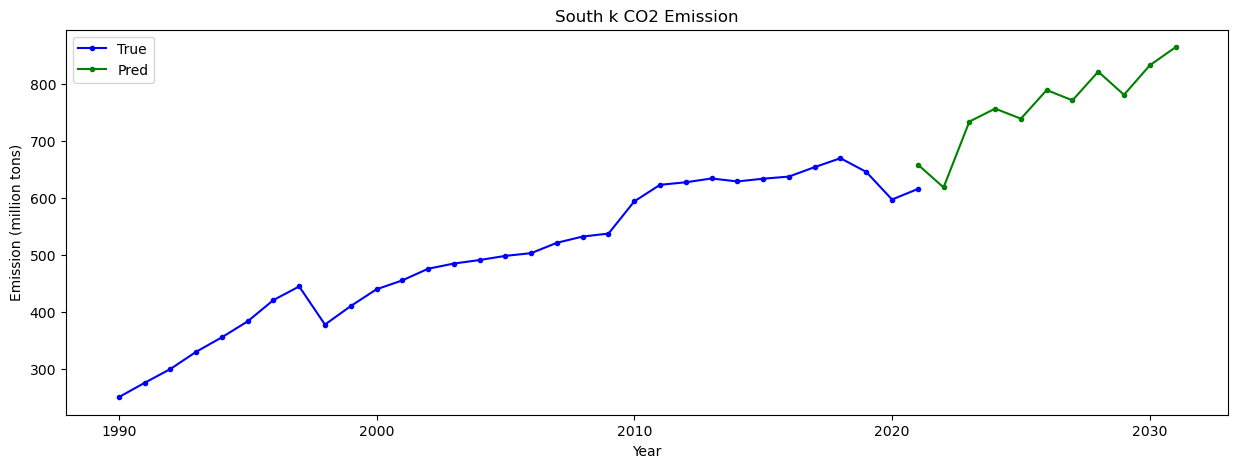

1/1 [==============================] - 0s 13ms/step
       r2_score        mae          mse       rmse
all    0.861345  23.392190  1157.000511  34.014710
train  0.864498  18.458192   641.544141  25.328722
val   -1.647327  57.783677  4749.419064  68.916029


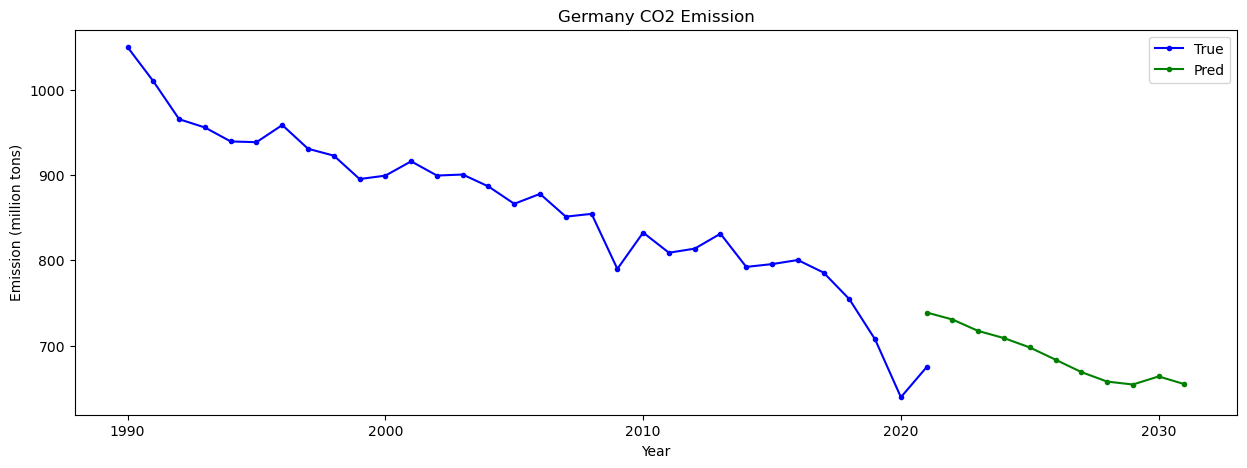

1/1 [==============================] - 0s 13ms/step
       r2_score        mae          mse       rmse
all    0.964434  22.594647   778.922253  27.909179
train  0.954777  21.376765   695.519851  26.372710
val   -1.875532  31.090859  1358.864796  36.862783


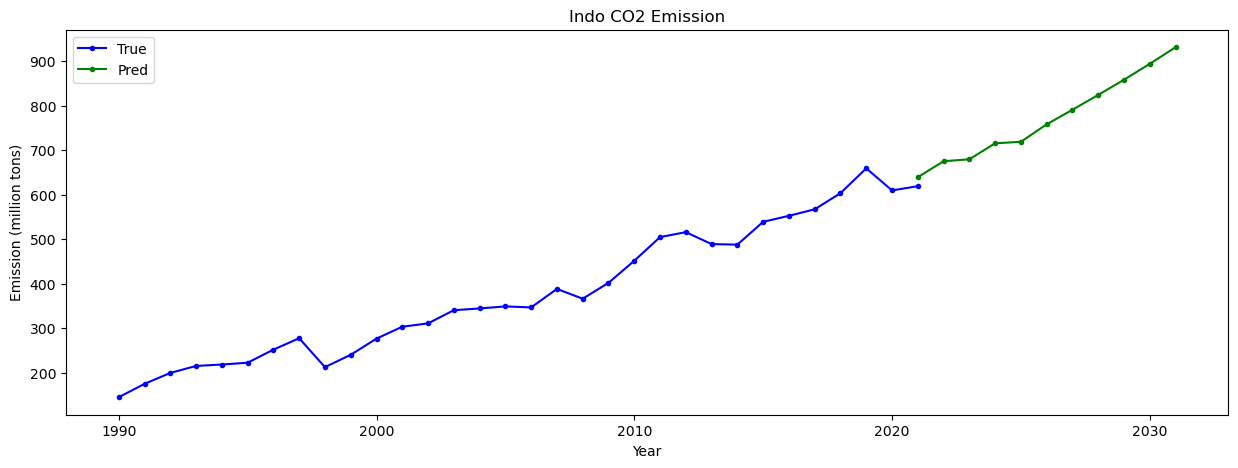

1/1 [==============================] - 0s 14ms/step
       r2_score        mae          mse       rmse
all    0.742189  42.987878  2466.808200  49.666973
train  0.744030  42.621345  2464.319178  49.641909
val   -7.299391  45.542995  2483.048193  49.830194


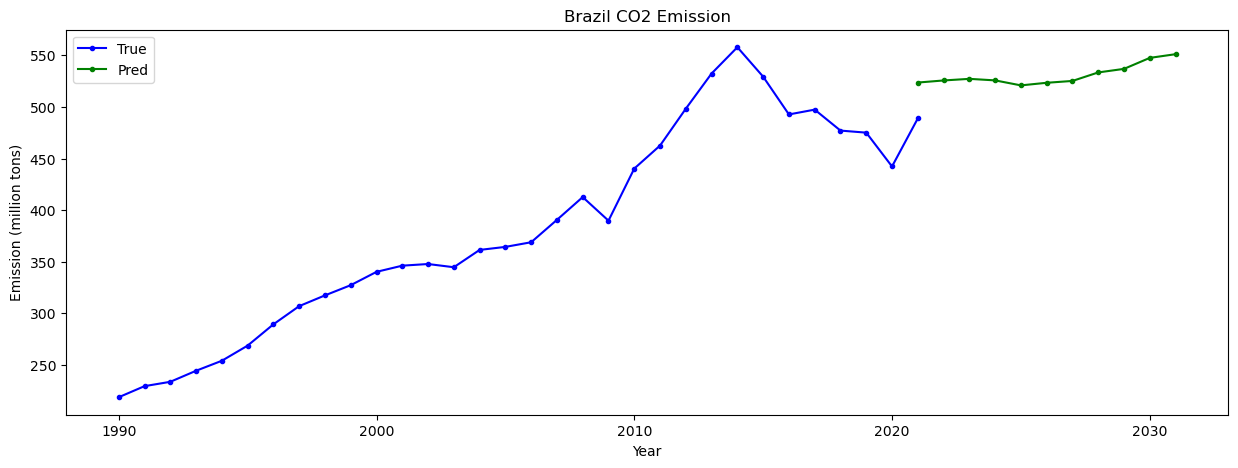

In [4]:
for c in countries:
    # importing model
    model = tf.keras.models.load_model(f'models/LSTM_{c}')
    
    # preping raw_data
    temp_ds = tf.data.Dataset.from_tensor_slices(df[c].values)
    temp_ds = temp_ds.window(size=window_size, drop_remainder=True, shift=1)
    temp_ds = temp_ds.flat_map(lambda window: window.batch(window_size))
    temp_ds = temp_ds.map(lambda window: (window[:-1], window[-1]))

    feat = []
    labels = []
    for x,y in temp_ds:
        feat.append(x.numpy())
        labels.append(y.numpy())
    feat = np.array(feat)
    labels = np.array(labels)
    idx = df.loc[df['سال'] == 2018].index.values-df.shape[0]
    
    # Spliting
    x_train_ts = feat[:idx[0]].reshape(-1, window_size-1)
    y_train_ts = labels[:idx[0]]
    x_val_ts = feat[idx[0]:].reshape(-1, window_size-1)
    y_val_ts = labels[idx[0]:]
    
    # Predicting
    pred_all = model.predict(feat.reshape(-1, window_size-1))
    pred_train = model.predict(x_train_ts)
    pred_val = model.predict(x_val_ts)
    
    # Infrence
    last = feat.reshape(-1, window_size-1)[-1]
    last = np.expand_dims(last, axis=0)
    
    inf = []
    for i in range(11):
        p = model.predict(last)
        last = np.expand_dims(np.append(last[:,1:], p),axis=0)
        inf.append(p[0,0])
    pred_inf = np.array(inf)
    years_inf = list(range(2021,2032))
    
    # saving results
    results = pd.DataFrame()
    results['Pred'] = pd.Series(np.concatenate((pred_all[:,0], pred_inf[1:])))
    results['True'] = pd.Series(labels)
    results.index = range(1990,2032)
    results.to_excel(f'Results/Result_{c}.xlsx')
    
    pred = {'all':pred_all, 'train':pred_train, 'val':pred_val}
    y_true = {'all':labels, 'train':y_train_ts, 'val':y_val_ts}

    # Metrics Results
    results_metrics = pd.DataFrame()
    results_metrics['r2_score'] = [r2_score(y_true[i], pred[i]) for i in pred]
    results_metrics['mae'] = [mean_absolute_error(y_true[i], pred[i]) for i in pred]
    results_metrics['mse'] = [mean_squared_error(y_true[i], pred[i]) for i in pred]
    results_metrics['rmse'] = [np.sqrt(mean_squared_error(y_true[i], pred[i])) for i in pred]
    results_metrics.index = [i for i in pred]
    results_metrics.to_excel(f'Results/Metrics/Metric_{c}.xlsx')
    print('='*100)
    print(results_metrics)
    print('='*100)
    
    #Plotting Predictions
    plt.figure(figsize=(15,5))
    plt.title(f'{c.capitalize()} CO2 Emission')
    
    ## true values
    plt.plot(df['سال'].values[-labels.shape[0]:], labels, color='b', marker='.')
    
    ## pred values
    #plt.plot(df['سال'].values[-labels.shape[0]:], pred_all, color='r', marker='.')
    
    ## inf values
    plt.plot(years_inf, pred_inf, color='g', marker='.')
    
    plt.xlabel('Year')
    plt.ylabel('Emission (million tons)')
    #plt.axvline(x=2018, color='black', ls='--')
    #plt.axvline(x=2021, color='black', ls='--')
    plt.legend(['True', 'Pred'])
    plt.savefig(f'Results/Plots/plot_{c}')
    plt.show()